## 导入库

In [1]:
import sklearn
import transformers
import torch

D:\ProgramData\Anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 数据预处理

### 加载数据

In [3]:
from transformers import BertTokenizer
import pandas as pd

def load_data(file_path):
    # 加载数据
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['question', 'label'])
    input_data = df['question'].tolist()
    labels = df['label'].tolist()
    return input_data, labels

train_data, train_labels = load_data('data/train.txt')
dev_data, dev_labels = load_data('data/dev.txt')
test_data, _ = load_data('data/test.txt')  # 测试集可能没有标签

In [4]:
train_data[0], train_labels[0]

('空腹血糖78，是否属于糖尿病范围?', 0)

### 分词与编码

In [5]:
def tokenize(input_data):
    # 加载分词器（Tokenizer）
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    # 分词与编码
    encoded_input = tokenizer(input_data, padding=True, truncation=True, max_length=25, return_tensors='pt').to(device)
    return encoded_input

encoded_train = tokenize(train_data)
encoded_dev = tokenize(dev_data)
encoded_test = tokenize(test_data)

In [6]:
# 查看第一个句子的词汇表索引及 Token
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
encoded_train['input_ids'][0], tokenizer.decode(encoded_train['input_ids'][0])

(tensor([ 101, 4958, 5592, 6117, 5131, 8409, 8024, 3221, 1415, 2247,  754, 5131,
         2228, 4567, 5745, 1741,  136,  102,    0,    0,    0,    0,    0,    0,
            0], device='cuda:0'),
 '[CLS] 空 腹 血 糖 78 ， 是 否 属 于 糖 尿 病 范 围? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]')

In [7]:
encoded_train

{'input_ids': tensor([[ 101, 4958, 5592,  ...,    0,    0,    0],
        [ 101, 1121, 5503,  ...,    0,    0,    0],
        [ 101, 2642, 3300,  ...,  671,  807,  102],
        ...,
        [ 101, 3633, 6226,  ...,    0,    0,    0],
        [ 101, 5131, 2228,  ...,    0,    0,    0],
        [ 101, 5131, 2228,  ...,    0,    0,    0]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

## 向量表示

### 获取BERT隐藏层的输出

In [8]:
from transformers import BertModel

def bert_hidden_states(model, encoded_data):
      
    model.to(device)
    # model.eval()

    # text = "空腹血糖5.8是否偏高?"
    hidden_states = []
    indexed_tokens = encoded_data  # 获取ids序列，即词汇表索引
    # print(indexed_tokens)
    # for tokens in encoded_data:
        # tokens_tensor = torch.tensor([indexed_tokens]).to(device) # 将输入转化为torch的tensor
    with torch.no_grad(): # 获取该句子在BERT模型中的隐藏层输出，禁用梯度计算，因为只是前向传播获取隐藏层状态，所以不需要计算梯度
        hidden_states = model(**indexed_tokens)
    # print(hidden_states[2])

    return hidden_states

In [9]:
encoded_train_part = {'input_ids': encoded_train['input_ids'][0:10], 'token_type_ids': encoded_train['token_type_ids'][0:10], 'attention_mask': encoded_train['attention_mask'][0:10]}
encoded_train_part['input_ids']

tensor([[ 101, 4958, 5592, 6117, 5131, 8409, 8024, 3221, 1415, 2247,  754, 5131,
         2228, 4567, 5745, 1741,  136,  102,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 1121, 5503, 1400, 3221, 1415, 5543, 3121, 1587, 5131, 2228, 4567,
         4307, 1105,  136,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 2642, 3300, 5131, 2228, 4567, 4638, 3678,  779, 5445, 4266,  779,
         3766, 3300, 8024, 3221, 1415,  833, 6890,  837, 5314,  678,  671,  807,
          102],
        [ 101, 5131, 2228, 4567, 3221, 1415,  833, 2471, 6629, 4706, 4714, 3717,
         5514,  136,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 1969, 2027, 3309, 5131, 2228, 4567, 4638, 3800, 2692,  752, 7555,
         3221,  784,  720,  136,  102,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 5131, 2228, 4567, 2642, 5442, 3221, 1415, 1377,  809, 4500, 1054,
         1346, 3796, 3717, 16

In [10]:
model = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True)  # 预训练的BERT模型
train_hidden_states = bert_hidden_states(model, encoded_train_part)
# dev_input_states = bert_hidden_states(model, encoded_dev)
# train_hidden_states

In [11]:
# train_hidden_states[0][0][0]
train_hidden_states['hidden_states'][-1].shape

torch.Size([10, 25, 768])

### 句子的向量表示

#### 取BERT第3, 6, 9, 12层的第一个token对应的向量

In [12]:
def vector1(hidden_states): 
    vectors = []

    for layer in [hidden_states[3], hidden_states[6], hidden_states[9], hidden_states[12]]:
        layer_vectors = []
        for state in layer:
            layer_vectors.append(state[0])
        layer_vectors = torch.stack(layer_vectors, dim=0)
        vectors.append(layer_vectors)
        
    # print(vectors)
    return torch.cat(vectors, dim=1)  # 将四个向量并成一个向量

#### 取BERT最后四层的第一个token对应的向量进行融合

In [13]:
def vector2(hidden_states): 
    vectors = []

    for layer in hidden_states[-4:]:
        layer_vectors = []
        for state in layer:
            layer_vectors.append(state[0])
        layer_vectors = torch.stack(layer_vectors, dim=0)
        vectors.append(layer_vectors)
        
    # print(vectors)
    return torch.cat(vectors, dim=1)  # 将四个向量并成一个向量

#### 取BERT最后四层第一个token对应的向量进行最大池化

In [14]:
def vector3(hidden_states): 
    vectors = []
    
    for layer in hidden_states[-4:]:
        layer_vectors = []
        for state in layer:
            layer_vectors.append(state[0])
        layer_vectors = torch.stack(layer_vectors, dim=0)
        vectors.append(layer_vectors)
        
    # print(torch.max(torch.stack(vectors), dim=0))
    return torch.max(torch.stack(vectors), dim=0).values  # 将四个向量并成一个向量

#### 取BERT最后一层第一个和最后一个token对应的向量进行融合

In [15]:
def vector4(last_hidden_state): 
    vectors = []

    for state in last_hidden_state:
        combine_tokens = (state[0] + state[-1]) / 2
        vectors.append(combine_tokens)
        # print(vectors)
    
    return torch.stack(vectors, dim=0)

#### 拼接最后一层隐藏层所有token的向量

In [16]:
def vector5(last_hidden_state):
    vectors = []

    for state in last_hidden_state:
        combine_tokens = []
        for token in state:
            combine_tokens.append(token)
        combine_tokens = torch.concat(combine_tokens)
        vectors.append(combine_tokens)
        # print(vectors)
    
    return torch.stack(vectors, dim=0)

In [17]:
x = torch.zeros_like(train_hidden_states['hidden_states'][-1])
for tensor in train_hidden_states['hidden_states'][-4:]:
    x += tensor
x.shape

torch.Size([10, 25, 768])

In [18]:
vector5(train_hidden_states['last_hidden_state']).shape

torch.Size([10, 19200])

## 定义模型架构

### 双向LSTM-Attention层

In [19]:
import torch

class LSTMAttention(torch.nn.Module):
    def __init__(self, hidden_size, classifier_dropout, num_labels=6, lstm_layers=1):
        super(LSTMAttention, self).__init__()

        # 双向LSTM
        self.lstm = torch.nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                            num_layers=lstm_layers,
                            bidirectional=True, batch_first=True)
        
        # 注意力机制
        self.attention = torch.nn.Linear(hidden_size * 2, 1)
        
        # dropout层
        self.dropout = nn.Dropout(classifier_dropout)

        # 分类层
        self.fc = torch.nn.Linear(hidden_size * 2, num_labels)  # 双向故乘以2

    def forward(self, hidden_states, dropout):
        # LSTM层
        lstm_out, _ = self.lstm(hidden_states)

        # 注意力机制
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        attn_output = torch.bmm(lstm_out.transpose(1, 2), attn_weights).squeeze(2)
        # print(attn_output.shape)
        
        if dropout == True:
            attn_output = self.dropout(attn_output)
        
        # 分类
        out = self.fc(attn_output)
        return out

### TextCNN

In [20]:
import torch
import torch.nn as nn
from transformers import BertModel

class TextCNN(nn.Module):
    def __init__(self, hidden_size, classifier_dropout, num_labels=6, num_filters=256, filter_sizes=[2,3,4]):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, num_filters, (k, hidden_size)) for k in filter_sizes]
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_labels)

    def forward(self, hidden_states, dropout):   
        
        x = torch.zeros_like(hidden_states[-1])
        for tensor in hidden_states[-3:]:
            x += tensor
        x = x.unsqueeze(1)  # 维度：(batch_size, 1, max_length, hidden_size)
        
        # TextCNN层
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # 维度：[(batch_size, num_filters, max_length-filter_size+1)] * len(filter_sizes)
        x = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # 维度：[(batch_size, num_filters)] * len(filter_sizes)
        x = torch.cat(x, 1)  # 维度：(batch_size, num_filters * len(filter_sizes))

        if dropout == True:
            x = self.dropout(x)
        # 分类    
        logits = self.fc(x)
        return logits

### 定义Bert网络结构

In [21]:
import torch.nn.functional as F

class BertClassifier(torch.nn.Module):
    def __init__(self, vector_type='last_four_layers_first_token', classifier_dropout=0.1, num_labels=6):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True)  # 加载预训练的BERT模型
        self.vector_size = self.bert.config.hidden_size  # 词向量大小
        self.vector_type = vector_type  # 词向量类型
        self.dropout = torch.nn.Dropout(classifier_dropout)  # Dropout层，防止过拟合，提高泛化能力
        self.classifier = torch.nn.Linear(self.vector_size, num_labels)  # 全连接层用于分类
        self.fc = torch.nn.Linear(4 * self.vector_size, self.vector_size)  # 四个向量的加权输入
        self.lstm_attention = LSTMAttention(self.vector_size, classifier_dropout)  # LSTM-Attention
        self.textcnn = TextCNN(self.vector_size, classifier_dropout)
        
        
    def forward(self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        dropout=True
    ):  
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)  # 经过一次BERT
        last_hidden_state = output[0]
        pooler_output = output[1]
        hidden_states = output[2]
        
        # 构建词向量并输出
        if self.vector_type == '3_6_9_12_layers_first_token':
            vectors = vector1(hidden_states)
            vectors = F.tanh(self.fc(vectors))  # 池化
            if dropout == True:
                vectors = self.dropout(vectors)  # 经过Dropout层
            logits = self.classifier(vectors)  # 经过全连接层
        elif self.vector_type == 'last_four_layers_first_token':
            vectors = vector2(hidden_states)
            vectors = F.tanh(self.fc(vectors))  # 池化
            if dropout == True:
                vectors = self.dropout(vectors)  # 经过Dropout层
            logits = self.classifier(vectors)
        elif self.vector_type == 'last_four_layers_first_token_max_pool':
            vectors = vector3(hidden_states)
            if dropout == True:
                vectors = self.dropout(vectors)  # 经过Dropout层
            logits = self.classifier(vectors)  # 经过全连接层
        elif self.vector_type == 'last_layer_first_and_last_token':
            vectors = vector4(last_hidden_state)
            if dropout == True:
                vectors = self.dropout(vectors)  # 经过Dropout层
            logits = self.classifier(vectors)  # 经过全连接层
        elif self.vector_type == 'last_four_layers_lstm':
            x = torch.zeros_like(hidden_states[-1])
            for tensor in hidden_states[-4:]:
                x += tensor
            logits = self.lstm_attention(x, dropout)
        elif self.vector_type == 'last_layer_lstm':
            logits = self.lstm_attention(last_hidden_state, dropout)
        elif self.vector_type == 'last_four_layers_max_pool_lstm':
            x = []
            for tensor in hidden_states[-4:]:
                x.append(tensor)
            x = torch.max(torch.stack(x), dim=0).values
            # print(x.shape)
            logits = self.lstm_attention(last_hidden_state, dropout)
        elif self.vector_type == 'textcnn':
            logits = self.textcnn(hidden_states, dropout)
        
        return logits

## 训练模型

### 模型预测

In [22]:
# 模型预测
def predict(model, encoded_data, batch_size=128):
    # 准备数据加载器
    dataset = TensorDataset(encoded_data['input_ids'], 
                                encoded_data['token_type_ids'], 
                                encoded_data['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    # 存储预测标签
    predictions = []

    with torch.no_grad():  # 无需计算梯度
        for inputs_ids, token_type_ids, attention_mask in loader:
            inputs = {'input_ids': inputs_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask, 'dropout': False}
            output = model(**inputs)
            # print(output)

            # 将模型输出转换为预测结果
            pred_labels = torch.argmax(output, dim=1)
            # print(pred_labels)
            predictions.extend(pred_labels.cpu().numpy())
            
    return predictions

### 对抗训练

In [23]:
# Fast Gradient Method 对抗训练类
class FGM:
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=1, emb_name='embeddings'):  # 向embedding层的参数加入扰动
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()  # 保存原始参数
                norm = torch.norm(param.grad)
                # print(norm)
                if norm != 0:
                    r_at = epsilon * param.grad / norm  # 计算扰动
                    param.data.add_(r_at)  # 添加扰动

    def restore(self, emb_name='embeddings'):  # 删除扰动
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]  # 恢复原始参数
        self.backup = {}

In [24]:
# bert_model = BertClassifier()
# for name, param in bert_model.named_parameters():
#     print(name)
#     if param.requires_grad and 'embeddings' in name:
#         # print(name, param.shape)
#         pass

### R-Drop

In [25]:
# 计算KL散度损失
def compute_kl_loss(p, q):
    
    p_loss = F.kl_div(F.log_softmax(p, dim=1), F.softmax(q, dim=1), reduction='none')
    q_loss = F.kl_div(F.log_softmax(q, dim=1), F.softmax(p, dim=1), reduction='none')
    
    p_loss = p_loss.mean()
    q_loss = q_loss.mean()
    
    loss = 0.5 * (p_loss + q_loss)
    
    return loss

# 计算R-Drop的损失函数
def r_drop_loss(logits1, logits2, labels, alpha):
    cross_entropy = torch.nn.CrossEntropyLoss()
    # print(y_pred1)
    loss1 = cross_entropy(logits1, labels)
    loss2 = cross_entropy(logits2, labels)
    ce_loss = 0.5 * (loss1 + loss2)
    kl_loss = compute_kl_loss(logits1, logits2)# 计算KL散度损失
    # print(loss1, kl_loss, kl_loss.shape)
    loss =  ce_loss + alpha * kl_loss
    # print(loss)
    return loss

### 分层学习率

In [26]:
def layer_learning_rate(model, classifier_lr=5e-5, gamma=0.95):
    # 从分类层开始，BERT各层学习率依次按衰减系数gamma向下层递减
    layer_lrs = [classifier_lr * (gamma ** (11 - i)) for i in range(12)]
    # print(layer_lrs)
    
    param_optimizer = list(model.named_parameters())
    optimizer_grouped_parameters = []

    # 全连接层和分类层的参数
    classifier_params = ['classifier.weight', 'classifier.bias', 'fc.weight', 'fc.bias']
    # 无需进行正则化的参数
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

    for name, param in param_optimizer:
        # print(name)
        # 检查是哪一层
        layer_index = None
        for i in range(12):
            if f'encoder.layer.{i}.' in name:
                layer_index = i
                break

        # 为全连接层和分类层设置学习率
        if name in classifier_params:
            lr = classifier_lr
        # 为BERT层设置学习率
        elif layer_index is not None:
            lr = layer_lrs[layer_index]
        # 其他层采用最低学习率（embedding层）
        else:
            lr = min(layer_lrs)
            # lr = 0 
        
        # 设置权重衰减参数
        if any(nd in name for nd in no_decay):
            weight_decay = 0.0
        else:
            weight_decay = 0.05
        
        param_config = {'params': [param], 'lr': lr, 'weight_decay': weight_decay}
        
        optimizer_grouped_parameters.append(param_config)
    
    return optimizer_grouped_parameters

# layer_learning_rate(bert_model)

### 设置随机数种子

In [27]:
import random
import os
def seed_torch(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 模型训练

In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import ExponentialLR, StepLR

def train(encoded_data, 
          labels, 
          batch_size, 
          vector_type, 
          classifier_dropout, 
          learning_rate, 
          epochs, 
          num_labels=6,
          validation=False,
          encoded_val=None,
          val_labels=None,
          warmup=0.1,
          epsilon=0,
          r_drop=False,
          alpha=2,
          verbose=True):
    
    # 准备数据加载器
    train_dataset = TensorDataset(encoded_data['input_ids'], 
                                  encoded_data['token_type_ids'], 
                                  encoded_data['attention_mask'], 
                                  labels)

    train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    
    # 计算输出日志的时间
    total_iterations = len(train_loader)
    check_point = math.floor(total_iterations / 10)
    # print(check_point)
    
    # 总训练步数 = 训练集大小 / 批量大小 * 总训练轮数
    total_steps = total_iterations * epochs
    print(f'总训练步数: {total_steps}')
    
    # 定义模型
    model = BertClassifier(vector_type, classifier_dropout, num_labels)
    model.to(device)

    # 优化器与损失函数
    # optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(layer_learning_rate(model, classifier_lr=learning_rate))  # 使用分层学习率  
    loss_function = torch.nn.CrossEntropyLoss()  # 使用交叉熵作为损失函数
    # 创建学习率调度器
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=total_steps * warmup,  # warmup比例的步数用于预热
                                                num_training_steps=total_steps)    
    
    # 对抗训练器
    fgm = FGM(model.bert)

    # 训练模型
    loss_list = []
    for epoch in range(epochs):  # 迭代次数
        count = 0
        for input_ids, token_type_ids, attention_mask, labels in train_loader:
            inputs = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}
            
            if r_drop == False:  # 不使用R-Drop方法进行训练
                # 正常训练
                logits = model(**inputs)  # 得到模型输出
                loss = loss_function(logits, labels.detach())
                loss.backward()
                    
            else:  # R-Drop训练
                logits1 = model(**inputs)
                logits2 = model(**inputs)
                loss = r_drop_loss(logits1, logits2, labels.detach(), alpha=alpha)  # 计算R_Drop的损失函数
                loss.backward()
            
            # 对抗训练
            if epsilon != 0:
                fgm.attack(epsilon=epsilon)  # 在embedding上添加对抗扰动
                logits_adv = model(**inputs)
                loss_adv = loss_function(logits_adv, labels.detach())
                loss_adv.backward()  # 对抗训练的梯度
                fgm.restore()  # 恢复embedding参数
            
            optimizer.step()  # 更新模型参数
            
            scheduler.step()  # 更新学习率
            optimizer.zero_grad()
            loss_list.append(loss.cpu().detach().numpy())
            
            count += 1
            if count % check_point == 0 and verbose == True:  # 打印日志信息
                print(f"epoch {epoch}, iterations {count}, loss: {loss}")
        
        # scheduler.step()  # 更新学习率
                
        if validation == True:  # 查看验证集得分情况
            val_pred = predict(model, encoded_val)
            accuracy = accuracy_score(val_labels, val_pred)
            print(f"epoch {epoch}, val_acc: {accuracy}")
                    
    if verbose == True:
        # 绘制损失曲线
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.plot(range(total_steps), loss_list)
        plt.show()

        # 绘制平滑处理后的损失曲线
        avg_loss_list = []
        avg_size = 15
        for i in range(total_steps - avg_size + 1):
            avg_loss_list.append(np.mean(loss_list[i : i + avg_size]))
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.plot(range(total_steps - avg_size + 1), avg_loss_list)
        plt.show()
    
    return model

总训练步数: 846
epoch 0, iterations 28, loss: 1.7586778402328491
epoch 0, iterations 56, loss: 0.823482871055603
epoch 0, iterations 84, loss: 0.6266524791717529
epoch 0, iterations 112, loss: 0.505796492099762
epoch 0, iterations 140, loss: 0.5947086811065674
epoch 0, iterations 168, loss: 0.362360417842865
epoch 0, iterations 196, loss: 0.4802160859107971
epoch 0, iterations 224, loss: 0.48953890800476074
epoch 0, iterations 252, loss: 0.5918397307395935
epoch 0, iterations 280, loss: 0.5975985527038574
epoch 0, val_acc: 0.771
epoch 1, iterations 28, loss: 0.43608081340789795
epoch 1, iterations 56, loss: 0.46932104229927063
epoch 1, iterations 84, loss: 0.39758121967315674
epoch 1, iterations 112, loss: 0.38639432191848755
epoch 1, iterations 140, loss: 0.2481880784034729
epoch 1, iterations 168, loss: 0.41337746381759644
epoch 1, iterations 196, loss: 0.2817205488681793
epoch 1, iterations 224, loss: 0.2583014965057373
epoch 1, iterations 252, loss: 0.363394170999527
epoch 1, iterations

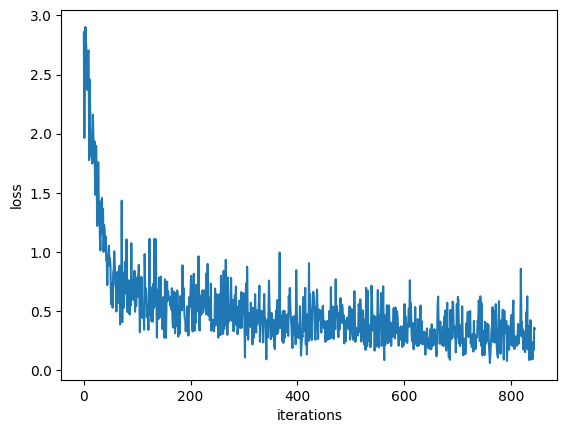

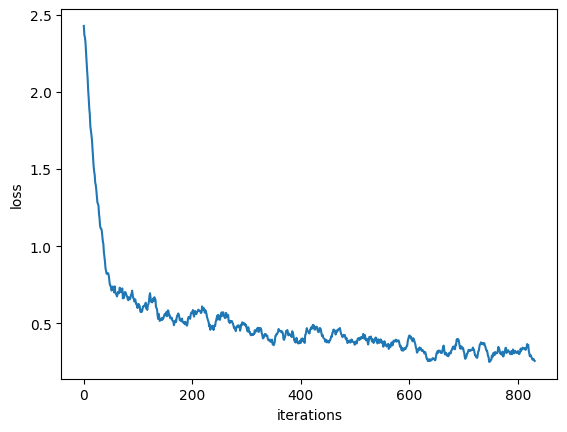

In [31]:
# 超参数
batch_size = 32  # 批处理大小
epochs = 3  # 训练次数
# vector_type = 'last_four_layers_first_token_max_pool'  # 向量表示类型
vector_type = 'textcnn'  # 向量表示类型
classifier_dropout = 0.5  # dropout层参数
learning_rate = 3e-5  # 学习率
warmup = 0.05  # 学习率预热步数的比例
epsilon = 0.2  # 对抗训练因子
r_drop = False  # 是否启用R-Drop方法
alpha = 4  # R-Drop参数
verbose = True  # 是否打印日志
validation = True  # 是否在验证集上进行验证
 
# 设置随机数种子
seed_torch(6666)

model = train(encoded_data=encoded_train,
              labels=torch.tensor(train_labels).to(device),
              batch_size=batch_size,
              vector_type=vector_type,
              classifier_dropout=classifier_dropout,
              learning_rate=learning_rate,
              epochs=epochs,
              warmup=warmup,
              encoded_val=encoded_dev,
              val_labels=dev_labels,
              epsilon=epsilon,
              r_drop=r_drop,
              alpha=alpha,
              verbose=verbose,
              validation=validation)

## 评估模型

In [32]:
# accuracy_list = []
# for i in range(5):
#     predictions = predict(model, encoded_dev)
#     accuracy = accuracy_score(dev_labels, predictions)
#     accuracy_list.append(accuracy)

# print(f'accuracy_list: {accuracy_list}')
# print(f'avg_accuracy: {np.mean(accuracy_list)}')
predictions = predict(model, encoded_dev)
print(accuracy_score(dev_labels, predictions))

0.7845


### 交叉验证

In [33]:
from sklearn.model_selection import KFold, StratifiedKFold

# 进行K折交叉验证进行模型评估
def cross_validation(k, all_data, all_labels):
    kf = KFold(n_splits=k, shuffle=True, random_state = 42)
    
    accuracy_list = []
    for train_index, valid_index in kf.split(all_labels):
        # print(train_index)
        train_data, val_data = [all_data[i] for i in train_index], [all_data[i] for i in valid_index]
        train_labels, val_labels = [all_labels[i] for i in train_index], [all_labels[i] for i in valid_index]

        encoded_train = tokenize(train_data)
        encoded_val = tokenize(val_data)
        
        model = train(encoded_data=encoded_train,
                      labels=torch.tensor(train_labels).to(device),
                      batch_size=batch_size,
                      vector_type=vector_type,
                      classifier_dropout=classifier_dropout,
                      learning_rate=learning_rate,
                      epochs=epochs,
                      warmup=warmup,
                      encoded_val=encoded_val,
                      val_labels=val_labels,
                      epsilon=epsilon,
                      r_drop=r_drop,
                      alpha=alpha,
                      verbose=False,
                      validation=True)
        
        predictions = predict(model, encoded_val)
        accuracy_list.append(accuracy_score(val_labels, predictions))
        
    print(f'accuracy_list: {accuracy_list}')
    print(f'avg_accuracy: {np.mean(accuracy_list)}')

In [34]:
# 合并数据集
all_data = train_data + dev_data
all_labels = train_labels + dev_labels

k = 5  # 交叉验证折数

# 设置随机数种子
torch.manual_seed(42)
    
# 超参数
batch_size = 32     
epochs = 3
vector_type = 'textcnn' 
classifier_dropout = 0.5
learning_rate = 3e-5
warmup = 0.1
epsilon = 0.2
r_drop = False
alpha = 2

cross_validation(k, all_data, all_labels)

总训练步数: 825
epoch 0, val_acc: 0.8336363636363636
epoch 1, val_acc: 0.84
epoch 2, val_acc: 0.8454545454545455
总训练步数: 825
epoch 0, val_acc: 0.8427272727272728
epoch 1, val_acc: 0.8490909090909091
epoch 2, val_acc: 0.8527272727272728
总训练步数: 825
epoch 0, val_acc: 0.8218181818181818
epoch 1, val_acc: 0.8354545454545454
epoch 2, val_acc: 0.8381818181818181
总训练步数: 825
epoch 0, val_acc: 0.8359090909090909
epoch 1, val_acc: 0.850909090909091
epoch 2, val_acc: 0.8513636363636363
总训练步数: 825
epoch 0, val_acc: 0.8240909090909091
epoch 1, val_acc: 0.8413636363636363
epoch 2, val_acc: 0.8377272727272728
accuracy_list: [0.8454545454545455, 0.8527272727272728, 0.8381818181818181, 0.8513636363636363, 0.8377272727272728]
avg_accuracy: 0.8450909090909091


## 完整数据集训练模型

### 使用R-Drop

总训练步数: 1032
epoch 0, iterations 34, loss: 1.283595085144043
epoch 0, iterations 68, loss: 0.9393514394760132
epoch 0, iterations 102, loss: 0.7079979181289673
epoch 0, iterations 136, loss: 0.5774810314178467
epoch 0, iterations 170, loss: 0.4480971395969391
epoch 0, iterations 204, loss: 0.40778738260269165
epoch 0, iterations 238, loss: 0.7936081290245056
epoch 0, iterations 272, loss: 0.4847557246685028
epoch 0, iterations 306, loss: 0.6038099527359009
epoch 0, iterations 340, loss: 0.4076443016529083
epoch 1, iterations 34, loss: 0.2698191702365875
epoch 1, iterations 68, loss: 0.29939621686935425
epoch 1, iterations 102, loss: 0.35978999733924866
epoch 1, iterations 136, loss: 0.46161654591560364
epoch 1, iterations 170, loss: 0.2730812728404999
epoch 1, iterations 204, loss: 0.23028050363063812
epoch 1, iterations 238, loss: 0.2623343765735626
epoch 1, iterations 272, loss: 0.5938357710838318
epoch 1, iterations 306, loss: 0.21254053711891174
epoch 1, iterations 340, loss: 0.2585

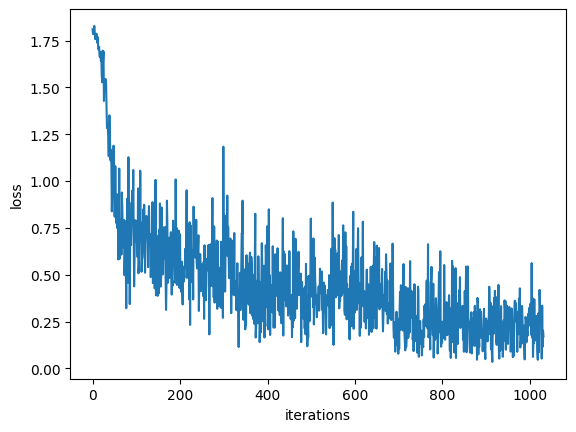

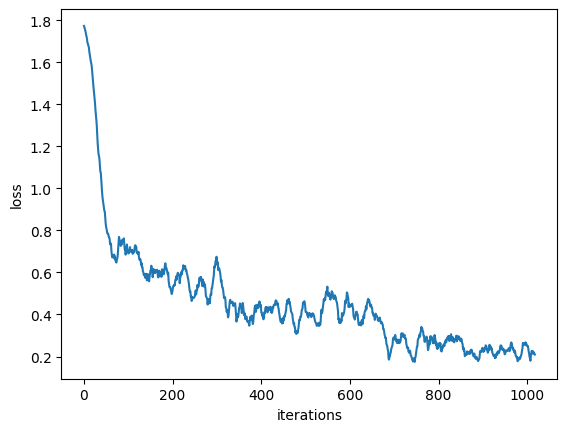

In [35]:
encoded_all = tokenize(all_data)

# 超参数
batch_size = 32
epochs = 3
vector_type = 'last_layer_lstm'
classifier_dropout = 0.1
learning_rate = 5e-5
warmup = 0.05
r_drop = False
alpha = 4

# 设置随机数种子
torch.manual_seed(41)

model = train(encoded_data=encoded_all,
              labels=torch.tensor(all_labels).to(device),
              batch_size=batch_size,
              vector_type=vector_type,
              classifier_dropout=classifier_dropout,
              learning_rate=learning_rate,
              epochs=epochs,
              r_drop=r_drop,
              alpha=alpha)

### 使用FGM对抗训练方法

总训练步数: 1032
epoch 0, iterations 34, loss: 0.8635455965995789
epoch 0, iterations 68, loss: 0.9795100092887878
epoch 0, iterations 102, loss: 0.703123927116394
epoch 0, iterations 136, loss: 0.6246747970581055
epoch 0, iterations 170, loss: 0.5166998505592346
epoch 0, iterations 204, loss: 0.399625301361084
epoch 0, iterations 238, loss: 0.7876058220863342
epoch 0, iterations 272, loss: 0.4877731204032898
epoch 0, iterations 306, loss: 0.5631750822067261
epoch 0, iterations 340, loss: 0.3751141130924225
epoch 1, iterations 34, loss: 0.21212568879127502
epoch 1, iterations 68, loss: 0.22005155682563782
epoch 1, iterations 102, loss: 0.3735394775867462
epoch 1, iterations 136, loss: 0.4805293381214142
epoch 1, iterations 170, loss: 0.2919315695762634
epoch 1, iterations 204, loss: 0.2175663560628891
epoch 1, iterations 238, loss: 0.3002605736255646
epoch 1, iterations 272, loss: 0.48191845417022705
epoch 1, iterations 306, loss: 0.24445852637290955
epoch 1, iterations 340, loss: 0.2425589

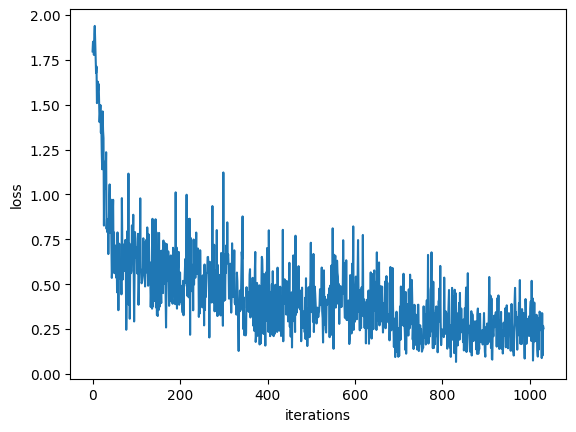

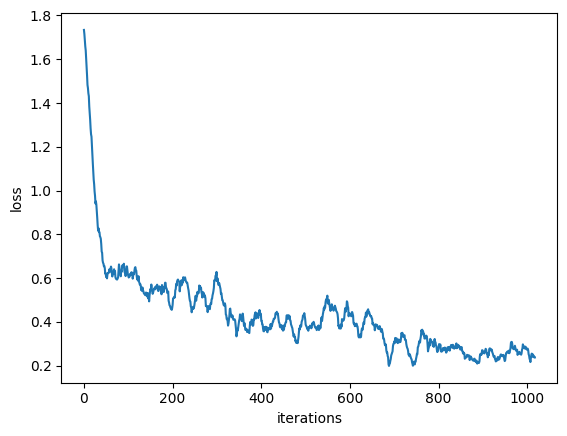

In [36]:
all_data = train_data + dev_data
all_labels = train_labels + dev_labels
encoded_all = tokenize(all_data)

# 超参数
num_labels = 6
batch_size = 32
epochs = 3
vector_type = 'last_four_layers_first_token_max_pool'
classifier_dropout = 0
learning_rate = 5e-5
warmup = 0.05
epsilon = 0.2
r_drop = False

# 设置随机数种子
torch.manual_seed(41)

model = train(encoded_data=encoded_all,
              labels=torch.tensor(all_labels).to(device),
              batch_size=batch_size,
              vector_type=vector_type,
              classifier_dropout=classifier_dropout,
              learning_rate=learning_rate,
              epochs=epochs,
              warmup=warmup,
              r_drop=r_drop,
              epsilon=epsilon)

## 保存模型

In [37]:
torch.save(model, 'model/bert_model_8.pth')

## 测试集预测

In [29]:
def submit(predictions):
    question = pd.read_csv('data/test.txt', delimiter='\t', header=None, names=['question', 'label'])['question'].tolist()
    # 生成提交文件
    submission_df = pd.DataFrame({'question': question, 'label': predictions})
    submission_df.to_csv('result/submission.txt', sep='\t', index=False, header=False)

In [39]:
    
test_predictions = predict(model, encoded_test)
submit(test_predictions)

## 模型集成

### Averaging集成

In [40]:
def averaging(model_list, model_weight):
    # 准备数据加载器
    batch_size = 128
    dataset = TensorDataset(encoded_test['input_ids'], 
                            encoded_test['token_type_ids'], 
                            encoded_test['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    # 存储预测标签
    predictions = []

    with torch.no_grad():  # 无需计算梯度
        for inputs_ids, token_type_ids, attention_mask in loader:
            inputs = {'input_ids': inputs_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask, 'dropout': False}
            # 将各模型预测结果相加
            pred_vec = torch.zeros([inputs_ids.shape[0], 6]).to(device)
            for model, weight in zip(model_list, model_weight):
                output = model(**inputs)
                pred_vec += output * weight
            # 转换为预测结果
            pred_labels = torch.argmax(pred_vec, dim=1)
            # print(pred_labels)
            predictions.extend(pred_labels.cpu().numpy())
            
    return predictions

In [48]:
# 加载模型
# model1 = torch.load('model/bert_model.pth')    # 78.70  单层drop  连接
# model2 = torch.load('model/bert_model_2.pth')  # 78.90  对抗训练  连接
model3 = torch.load('model/bert_model_3.pth')  # 79.40  对抗训练  最大池化
model4 = torch.load('model/bert_model_4.pth')  # 79.30  R-Drop   连接
model5 = torch.load('model/bert_model_5.pth')  # 79.45  对抗训练  LSTM-Attention
model6 = torch.load('model/bert_model_6.pth')  # 79.70  对抗训练  TextCNN
# model7 = torch.load('model/bert_model_7.pth')  # 79.70  对抗训练  TextCNN

model_list = [model3, model5, model6]  # 模型列表
model_weight = [1.0, 1.1, 1.08]  # 模型权重

combined_predictions = averaging(model_list, model_weight)
submit(combined_predictions) 

### Voting集成

In [49]:
from scipy.stats import mode
def voting(prediction_tuple):
    # 将数组堆叠起来
    stacked_arrays = np.vstack(prediction_tuple)

    # 使用投票法进行融合
    # mode() 函数返回最频繁出现的元素及其出现次数
    combined_predictions = mode(stacked_arrays, axis=0).mode
    
    return combined_predictions

In [50]:
predictions1 = predict(model6, encoded_test)
predictions2 = predict(model5, encoded_test)
predictions3 = predict(model4, encoded_test)
prediction_tuple = predictions1, predictions2, predictions3
combined_predictions = voting(prediction_tuple)

In [51]:
submit(combined_predictions)

### Stacking集成

In [30]:
from sklearn.model_selection import KFold

def get_logits(model, encoded_data, batch_size=1024):  # 获取模型输出
    # 准备数据加载器
    dataset = TensorDataset(encoded_data['input_ids'], 
                            encoded_data['token_type_ids'], 
                            encoded_data['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size)

    # 存储模型输出
    logits = []

    with torch.no_grad():  # 无需计算梯度
        for inputs_ids, token_type_ids, attention_mask in loader:
            inputs = {'input_ids': inputs_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask, 'dropout': False}
            output = model(**inputs)
            logits.extend(output.cpu().numpy())
            
    return np.array(logits)

#### 第一层训练

In [31]:
# stacking第一层训练：训练基学习器得到元学习器的训练集和测试集的输入
def stacking_base_train(kf, model_param, encoded_all, all_labels, encoded_test):
    val_output = [[] for _ in range(len(all_labels))]  # 存储单个基模型对训练集的预测
    test_output = []  # 存储单个基模型对测试集的预测
    # 对单个基模型进行k折交叉验证的训练
    for train_index, valid_index in kf.split(all_labels, all_labels):
        encoded_train = {'input_ids': torch.index_select(encoded_all['input_ids'], 0, torch.tensor(train_index).to(device)),
                         'token_type_ids': torch.index_select(encoded_all['token_type_ids'], 0, torch.tensor(train_index).to(device)),
                         'attention_mask': torch.index_select(encoded_all['attention_mask'], 0, torch.tensor(train_index).to(device))}
        encoded_val = {'input_ids': torch.index_select(encoded_all['input_ids'], 0, torch.tensor(valid_index).to(device)),
                         'token_type_ids': torch.index_select(encoded_all['token_type_ids'], 0, torch.tensor(valid_index).to(device)),
                         'attention_mask': torch.index_select(encoded_all['attention_mask'], 0, torch.tensor(valid_index).to(device))}
        train_labels, val_labels = [all_labels[i] for i in train_index], [all_labels[i] for i in valid_index]

        model_param['encoded_data'] = encoded_train
        model_param['labels'] = torch.tensor(train_labels).to(device)
        model_param['encoded_val'] = encoded_val
        model_param['val_labels'] = val_labels

        model = train(**model_param)

        logits_val = get_logits(model, encoded_val) # 单模型对这一折的验证集的预测输出
        for i, val_i in enumerate(valid_index):
            val_output[val_i] = logits_val[i]
        logits_test = get_logits(model, encoded_test)  # 单模型对测试集的预测输出
        test_output.append(logits_test)
        
    val_output = np.array(val_output)
    test_output = np.mean(test_output, axis=0)  # averaging得到测试集的预测输出
        
    return val_output, test_output

In [32]:
from sklearn.model_selection import KFold, StratifiedKFold
# 合并数据集
all_data = train_data + dev_data
all_labels = train_labels + dev_labels
# all_data = aeda_train_data + aeda_dev_data
# all_labels = aeda_train_labels + aeda_dev_labels

encoded_all = tokenize(all_data)

base_model_params = [    # 基模型参数列表
                        {
                            'batch_size': 32,
                            'epochs': 2,
                            'vector_type': 'last_four_layers_lstm',
                            'classifier_dropout': 0.2,
                            'learning_rate': 3e-5,
                            'warmup': 0.1,
                            'epsilon': 0.2,
                            'r_drop': False,
                            'verbose': False,
                            'validation': True
                         },
                         {
                            'batch_size': 32,
                            'epochs': 3,
                            'vector_type': 'last_layer_lstm',
                            'classifier_dropout': 0.2,
                            'learning_rate': 3e-5,
                            'warmup': 0.1,
                            'epsilon': 0.2,
                            'r_drop': False,
                            # 'alpha': 2,
                            'verbose': False,
                            'validation': True
                         },
                         {
                            'batch_size': 32,
                            'epochs': 3,
                            'vector_type': 'textcnn',
                            'classifier_dropout': 0.5,
                            'learning_rate': 3e-5,
                            'warmup': 0.1,
                            'epsilon': 0.2,
                            'r_drop': False,
                            'verbose': False,
                            'validation': True
                         },
                         # {
                         #    'batch_size': 32,
                         #    'epochs': 3,
                         #    'vector_type': '3_6_9_12_layers_first_token',
                         #    'classifier_dropout': 0.2,
                         #    'learning_rate': 5e-5,
                         #    'lr_gamma': 0.2,
                         #    'epsilon': 0,
                         #    'r_drop': True,
                         #    'alpha': 2,
                         #    'verbose': False,
                         #    'validation': True
                         # },
                    ]

# 设置随机数种子
torch.manual_seed(42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

base_model_train = []  # 存储所有基模型对训练集的预测 
base_model_test = []   # 存储所有基模型对测试集的预测
for i, model_param in enumerate(base_model_params):
    print(f'Model{i+1}: ')
    val_output, test_output = stacking_base_train(kf, model_param, encoded_all, all_labels, encoded_test)
    base_model_train.append(val_output)
    base_model_test.append(test_output)

base_model_train = np.concatenate(base_model_train, axis=1)  # 将各基模型的输出拼接成一个向量
base_model_test = np.concatenate(base_model_test, axis=1)

Model1: 
总训练步数: 550
epoch 0, val_acc: 0.8331818181818181
epoch 1, val_acc: 0.8404545454545455
总训练步数: 550
epoch 0, val_acc: 0.8436363636363636
epoch 1, val_acc: 0.8518181818181818
总训练步数: 550
epoch 0, val_acc: 0.8281818181818181
epoch 1, val_acc: 0.8427272727272728
总训练步数: 550
epoch 0, val_acc: 0.8377272727272728
epoch 1, val_acc: 0.8495454545454545
总训练步数: 550
epoch 0, val_acc: 0.8363636363636363
epoch 1, val_acc: 0.845
Model2: 
总训练步数: 825
epoch 0, val_acc: 0.835
epoch 1, val_acc: 0.8459090909090909
epoch 2, val_acc: 0.8536363636363636
总训练步数: 825
epoch 0, val_acc: 0.8377272727272728
epoch 1, val_acc: 0.8518181818181818
epoch 2, val_acc: 0.850909090909091
总训练步数: 825
epoch 0, val_acc: 0.8372727272727273
epoch 1, val_acc: 0.8395454545454546
epoch 2, val_acc: 0.8431818181818181
总训练步数: 825
epoch 0, val_acc: 0.8372727272727273
epoch 1, val_acc: 0.8481818181818181
epoch 2, val_acc: 0.8522727272727273
总训练步数: 825
epoch 0, val_acc: 0.8318181818181818
epoch 1, val_acc: 0.8377272727272728
epoch 2, va

In [33]:
base_model_train.shape

(11000, 18)

#### 第二层训练

In [34]:
from sklearn.linear_model import LogisticRegression
# stacking第二层训练：训练元学习器并得到测试集的预测结果
def stacking_meta_train(base_model_train, train_labels, base_model_test):
    meta_model = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs', max_iter=1000)  # 使用逻辑回归模型作为元学习器
    meta_model.fit(base_model_train, train_labels)
    predictions = meta_model.predict(base_model_test)
    return predictions

In [35]:
predictions = stacking_meta_train(base_model_train, all_labels, base_model_test)
submit(predictions)